In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from math import *
import csv
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from pandas import concat
from pandas import DataFrame

from math import sqrt
from numpy import concatenate


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [24]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [25]:
dataPath = "project\data\wow.csv"
data = pd.read_csv(dataPath)
data=data.iloc[:,32:33]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
reframed = series_to_supervised(scaled, 1, 1)
reframed

,var1(t-1),var1(t)
1,0.357955,0.386364
2,0.386364,0.403409
3,0.403409,0.357955
4,0.357955,0.363636
5,0.363636,0.318182
...,...,...
936,0.017045,0.017045
937,0.017045,0.011364
938,0.011364,0.022727
939,0.022727,0.079545


In [26]:
values = reframed.values
n_train_hours = 365*2
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1:]  
test_X, test_y = test[:, :-1], test[:, -1:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(730, 1, 1) (730, 1) (210, 1, 1) (210, 1)


Epoch 1/100
15/15 - 7s - loss: 0.2255 - val_loss: 0.1278 - 7s/epoch - 495ms/step
Epoch 2/100
15/15 - 0s - loss: 0.1711 - val_loss: 0.0853 - 103ms/epoch - 7ms/step
Epoch 3/100
15/15 - 0s - loss: 0.1279 - val_loss: 0.0715 - 110ms/epoch - 7ms/step
Epoch 4/100
15/15 - 0s - loss: 0.1047 - val_loss: 0.0781 - 100ms/epoch - 7ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0980 - val_loss: 0.0840 - 99ms/epoch - 7ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0959 - val_loss: 0.0829 - 107ms/epoch - 7ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0938 - val_loss: 0.0798 - 101ms/epoch - 7ms/step
Epoch 8/100
15/15 - 0s - loss: 0.0920 - val_loss: 0.0777 - 105ms/epoch - 7ms/step
Epoch 9/100
15/15 - 0s - loss: 0.0902 - val_loss: 0.0764 - 100ms/epoch - 7ms/step
Epoch 10/100
15/15 - 0s - loss: 0.0886 - val_loss: 0.0747 - 102ms/epoch - 7ms/step
Epoch 11/100
15/15 - 0s - loss: 0.0870 - val_loss: 0.0729 - 92ms/epoch - 6ms/step
Epoch 12/100
15/15 - 0s - loss: 0.0854 - val_loss: 0.0713 - 88ms/epoch - 6ms/step
Epoch 13/100
15/1

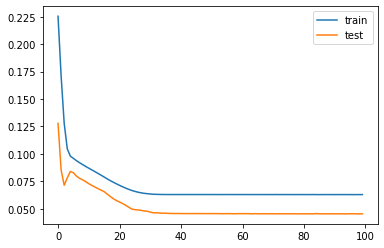

Test RMSE: 50.268
R²: 0.6746116482044318


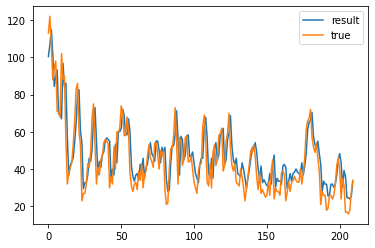

[array([33.560787], dtype=float32), array([38.08866], dtype=float32), array([41.80498], dtype=float32), array([44.874645], dtype=float32), array([47.423203], dtype=float32), array([49.547966], dtype=float32), array([51.325485], dtype=float32), array([52.816708], dtype=float32), array([54.070675], dtype=float32), array([55.127197], dtype=float32), array([56.018814], dtype=float32), array([56.772293], dtype=float32), array([57.40977], dtype=float32), array([57.949615], dtype=float32), array([58.40716], dtype=float32), array([58.79522], dtype=float32), array([59.124535], dtype=float32), array([59.40413], dtype=float32), array([59.64162], dtype=float32), array([59.843414], dtype=float32), array([60.014935], dtype=float32), array([60.16075], dtype=float32), array([60.28474], dtype=float32), array([60.390198], dtype=float32), array([60.479904], dtype=float32), array([60.556225], dtype=float32), array([60.621155], dtype=float32), array([60.67641], dtype=float32), array([60.723434], dtype=floa

In [27]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
yhatInverse = scaler.inverse_transform(yhat)
test_y_Inserve = scaler.inverse_transform(test_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(test_X, yhat))
print('Test RMSE: %.3f' % rmse)
print("R²:",r2_score(test_y_Inserve,yhatInverse))
predictionAQISeven=[]
predictionAQISeven.append(yhatInverse[len(yhatInverse)-1])
predictionAQISeven
plt.plot(yhatInverse,label="result")
plt.plot(test_y_Inserve,label="true")
plt.legend()
plt.show()
# for i in range(50):
#     test = yhat.reshape(yhat.shape[0],1,yhat.shape[1])
#     yhat = model.predict(test)
#     yhatInverse = scaler.inverse_transform(yhat)
#     predictionAQISeven.append(yhatInverse[len(yhatInverse)-1])
# print(predictionAQISeven)